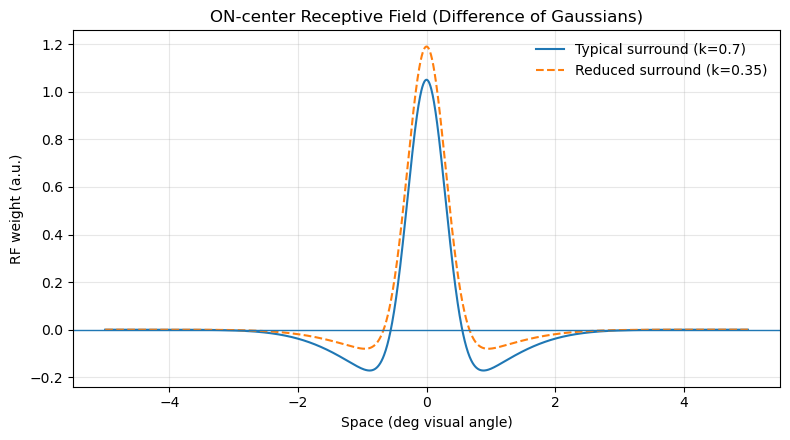

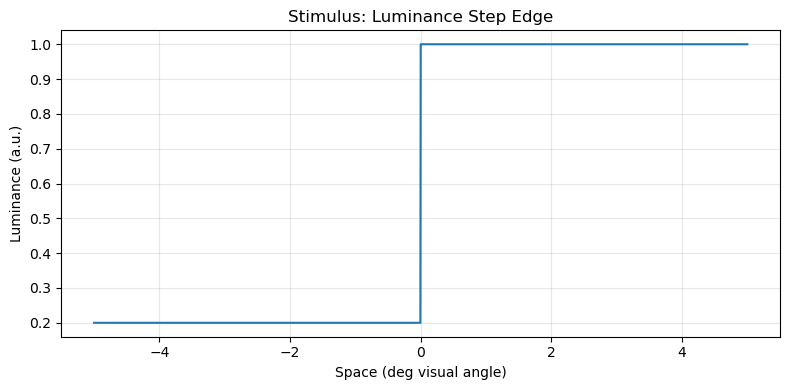

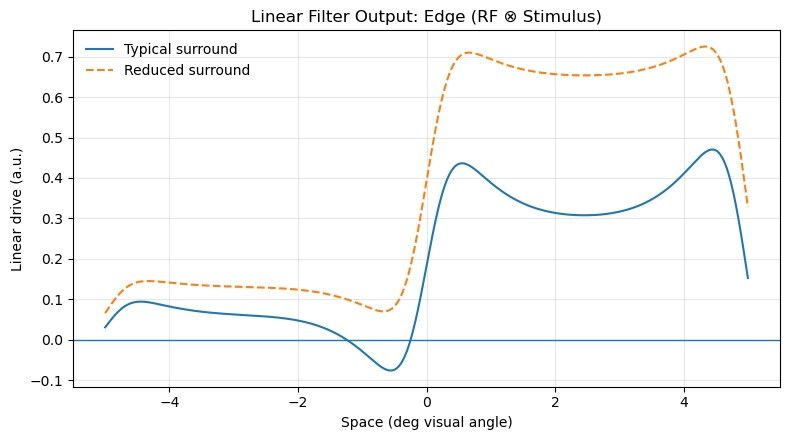

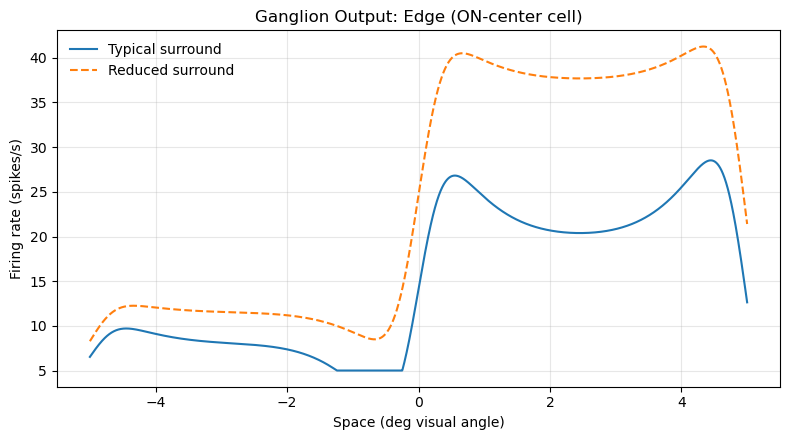

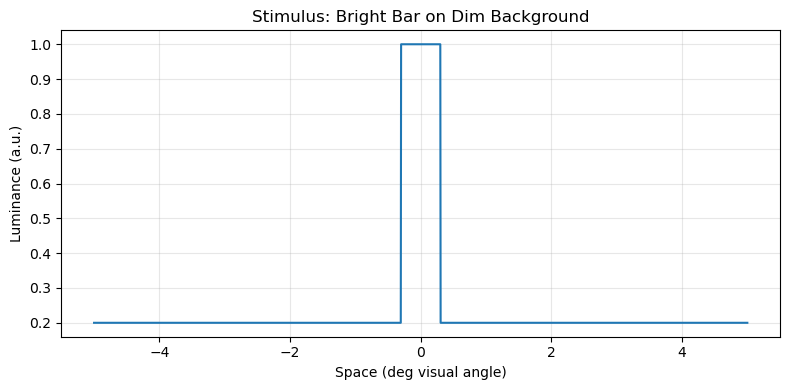

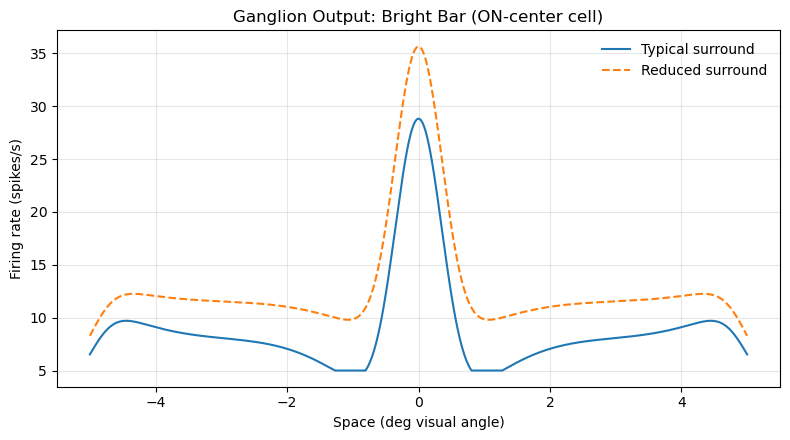

In [1]:
# Project-Checkpoint-1
# =====================================
# Neural Mechanism Model (Human Retina: Center–Surround with Lateral Inhibition)
# =====================================
# PURPOSE
#   Simulate an ON-center retinal ganglion cell's receptive field (Difference of Gaussians, DoG)
#   and its response to simple spatial stimuli. The antagonistic surround term
#   approximates horizontal-cell–mediated lateral inhibition.
#
# FILE ORGANIZATION
#   1) Imports & global plotting defaults
#   2) Model parameters (units noted)
#   3) Helper math (Gaussians, DoG RF)  <-- pre-def comments explain biology & I/O
#   4) Stimulus generators (edge, bar)
#   5) Linear filter stage (convolution with RF)
#   6) Nonlinear spike-rate stage (rectified output)
#   7) Build RFs & stimuli
#   8) Compute responses
#   9) Figures (each with axis labels in biological units)
#
# BIOLOGICAL MAPPING
#   Photoreceptors -> Bipolar (center excitation)
#                \-> Horizontal (surround inhibition)
#   Bipolar/Horizontal -> Ganglion (rectified spikes/s)
#
# UNITS
#   Space: degrees of visual angle (deg)
#   Luminance: arbitrary units (a.u.)
#   RF/linear drive: a.u.
#   Firing rate: spikes/s

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# (1) GLOBAL SETTINGS
# ------------------------------
rng = np.random.default_rng(7)  # for reproducibility if adding noise later

# ------------------------------
# (2) MODEL PARAMETERS (with units)
# ------------------------------
x = np.linspace(-5, 5, 2001)   # deg visual angle (spatial axis)
sigma_center = 0.3             # deg; RF center width (parvocellular-like foveal scale)
sigma_surround = 1.0           # deg; broader inhibitory surround
k_surround_typical = 0.7       # dimensionless; surround gain (typical)
k_surround_reduced  = 0.35     # dimensionless; reduced inhibition ("schizophrenia-like")

baseline_rate = 5.0            # spikes/s; spontaneous firing
gain = 50.0                    # spikes/s per a.u. linear drive
max_rate = 120.0               # spikes/s; soft saturation cap

# ------------------------------
# (3) HELPER MATH — Receptive Field building blocks
# ------------------------------
# Pre-def explanation:
#   gaussian_1d(x, sigma): normalized 1D Gaussian (spatial weighting).
#   receptive_field_DoG(...): ON-center DoG = center - k*surround.
#   I/O: x (deg) -> RF weights (a.u.).
def gaussian_1d(x, sigma):
    """Return a normalized 1D Gaussian with std 'sigma' (deg). Output: a.u. weights."""
    return (1.0 / (np.sqrt(2*np.pi)*sigma)) * np.exp(-(x**2) / (2*sigma**2))

def receptive_field_DoG(x, sigma_c, sigma_s, k):
    """
    Difference-of-Gaussians RF (ON-center): center - k*surround.
      Inputs:
        x        : spatial positions (deg)
        sigma_c  : center std (deg), excitatory
        sigma_s  : surround std (deg), inhibitory (broader)
        k        : surround gain (dimensionless)
      Output:
        rf(x)    : spatial weights (a.u.); positive = excitatory, negative = inhibitory
    """
    center = gaussian_1d(x, sigma_c)
    surround = gaussian_1d(x, sigma_s)
    return center - k * surround

# ------------------------------
# (4) STIMULUS GENERATORS (space -> luminance)
# ------------------------------
# Pre-def explanation:
#   step_edge: light area on dark with a clear boundary
#   bright_bar: bright rectangular bar on a dark background
#   Outputs are luminance in a.u.
def step_edge(x, edge_at=0.0, low=0.2, high=1.0):
    """Luminance step: low (x<edge_at) -> high (x>=edge_at). Units: a.u."""
    return np.where(x < edge_at, low, high)

def bright_bar(x, center=0.0, half_width=0.3, background=0.2, peak=1.0):
    """Rectangular bright bar centered at 'center' with 'half_width'. Units: a.u."""
    bar = ((x >= center-half_width) & (x <= center+half_width)).astype(float)
    return background + (peak - background) * bar

# ------------------------------
# (5) LINEAR FILTER STAGE (RF ⊗ stimulus)
# ------------------------------
# Pre-def explanation:
#   linear_response: approximate bipolar summation + horizontal surround via 1D convolution.
#   combination of inhibitory (surrond) and excitatory inputs before reaching the ganglion cell
#   Multiply by dx to approximate continuous integral.
def linear_response(stim, rf, x):
    """Return linear drive = (stimulus * RF) convolved over space. Output: a.u."""
    dx = np.mean(np.diff(x))
    return np.convolve(stim, rf, mode='same') * dx

# ------------------------------
# (6) NONLINEAR SPIKE-RATE STAGE
# ------------------------------
# Pre-def explanation:
#   rectified_rate: half-wave rectifier + soft cap to mimic spike generation.
#   Inputs: linear drive (a.u.). Output: spikes/s.
def rectified_rate(u, baseline=5.0, gain=50.0, rmax=120.0):
    """Map linear drive (a.u.) to firing rate (spikes/s) with baseline and cap."""
    r = baseline + gain * np.maximum(u, 0.0)
    return np.minimum(r, rmax)

# ------------------------------
# (7) BUILD RFs
# ------------------------------
rf_typical = receptive_field_DoG(x, sigma_center, sigma_surround, k_surround_typical)
rf_reduced = receptive_field_DoG(x, sigma_center, sigma_surround, k_surround_reduced)

# ------------------------------
# (8) CREATE STIMULI & COMPUTE RESPONSES
# ------------------------------
stim_edge = step_edge(x, edge_at=0.0, low=0.2, high=1.0)
stim_bar  = bright_bar(x, center=0.0, half_width=0.3, background=0.2, peak=1.0)

lin_edge_typical  = linear_response(stim_edge, rf_typical, x)
lin_edge_reduced  = linear_response(stim_edge, rf_reduced, x)
lin_bar_typical   = linear_response(stim_bar,  rf_typical, x)
lin_bar_reduced   = linear_response(stim_bar,  rf_reduced, x)

fr_edge_typical = rectified_rate(lin_edge_typical, baseline_rate, gain, max_rate)
fr_edge_reduced = rectified_rate(lin_edge_reduced, baseline_rate, gain, max_rate)
fr_bar_typical  = rectified_rate(lin_bar_typical,  baseline_rate, gain, max_rate)
fr_bar_reduced  = rectified_rate(lin_bar_reduced,  baseline_rate, gain, max_rate)

# ------------------------------
# (9) PLOTTING HELPERS
# ------------------------------
def finalize_axes(ax, xlabel, ylabel, title):
    """Apply consistent labels, title, and light grid (no specific colors)."""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# ------------------------------
# (10) FIGURES (one plot per figure)
# ------------------------------
plt.figure(figsize=(8,4.5))
plt.plot(x, rf_typical, label='Typical surround (k=0.7)')
plt.plot(x, rf_reduced, label='Reduced surround (k=0.35)', linestyle='--')
plt.axhline(0, linewidth=1)
plt.legend(frameon=False)
finalize_axes(plt.gca(), 'Space (deg visual angle)', 'RF weight (a.u.)',
              'ON-center Receptive Field (Difference of Gaussians)')
plt.tight_layout()
plt.savefig('fig1_receptive_field.png', dpi=200)

plt.figure(figsize=(8,4))
plt.plot(x, stim_edge)
finalize_axes(plt.gca(), 'Space (deg visual angle)', 'Luminance (a.u.)',
              'Stimulus: Luminance Step Edge')
plt.tight_layout()
plt.savefig('fig2_stim_edge.png', dpi=200)

plt.figure(figsize=(8,4.5))
plt.plot(x, lin_edge_typical, label='Typical surround')
plt.plot(x, lin_edge_reduced, label='Reduced surround', linestyle='--')
plt.axhline(0, linewidth=1)
plt.legend(frameon=False)
finalize_axes(plt.gca(), 'Space (deg visual angle)', 'Linear drive (a.u.)',
              'Linear Filter Output: Edge (RF ⊗ Stimulus)')
plt.tight_layout()
plt.savefig('fig3_linear_edge.png', dpi=200)

plt.figure(figsize=(8,4.5))
plt.plot(x, fr_edge_typical, label='Typical surround')
plt.plot(x, fr_edge_reduced, label='Reduced surround', linestyle='--')
plt.legend(frameon=False)
finalize_axes(plt.gca(), 'Space (deg visual angle)', 'Firing rate (spikes/s)',
              'Ganglion Output: Edge (ON-center cell)')
plt.tight_layout()
plt.savefig('fig4_rate_edge.png', dpi=200)

plt.figure(figsize=(8,4))
plt.plot(x, stim_bar)
finalize_axes(plt.gca(), 'Space (deg visual angle)', 'Luminance (a.u.)',
              'Stimulus: Bright Bar on Dim Background')
plt.tight_layout()
plt.savefig('fig5_stim_bar.png', dpi=200)

plt.figure(figsize=(8,4.5))
plt.plot(x, fr_bar_typical, label='Typical surround')
plt.plot(x, fr_bar_reduced, label='Reduced surround', linestyle='--')
plt.legend(frameon=False)
finalize_axes(plt.gca(), 'Space (deg visual angle)', 'Firing rate (spikes/s)',
              'Ganglion Output: Bright Bar (ON-center cell)')
plt.tight_layout()
plt.savefig('fig6_rate_bar.png', dpi=200)